In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import math

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import matplotlib.patches as mpatches

# Classifying fruit


Now that we have an idea of how kNN classification works, let us consider a more advanced example that includes cross validation to tune the parameter $k$, a measure of accuracy, and discussion on the data itself. Below we load in the data.


This data contains measurements on actual fruits: apples, lemons, oranges, and mandarins compiled by [Iain Murray, PhD](https://homepages.inf.ed.ac.uk/imurray2/teaching/oranges_and_lemons/) and expanded on by [Susan Li](https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/fruit_data_with_colors.txt).
It contains the following features: width (cm), height (cm), mass(g), colorscore(0 - 1 scale).


We focus on width and height features to determine if we can classify fruit. Note we need a few of the functions defined thus far, so we redefine them below for easy access.

In [3]:
# the Euclidean distance
def distance(pt1, pt2):   
    """Return the distance between two points, represented as arrays"""
    return np.sqrt(sum((pt1 - pt2)**2))

def row_wise_distance(row, my_point):
    '''Computes the distance between the given my_point and a single df row'''
    return distance(my_point, np.array(row))

def closest_k(df, point, k):
    """Outputs a df containing the k closest rows in the input df to array 'point' """
    df = df.assign(Distance_to_point = df.apply(row_wise_distance, args=(point,), axis=1))
    df = df.sort_values('Distance_to_point') 
    topk = df.head(k)
    return topk

In [4]:
fruit_df = pd.read_csv('../../data/fruit_data_with_colors.txt', sep="\t")
fruit_df.head()

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
0,1,apple,granny_smith,192,8.4,7.3,0.55
1,1,apple,granny_smith,180,8.0,6.8,0.59
2,1,apple,granny_smith,176,7.4,7.2,0.60
3,2,mandarin,mandarin,86,6.2,4.7,0.80
4,2,mandarin,mandarin,84,6.0,4.6,0.79


Although we can get a general sense of the algorithm using raw data, we do want to be careful about the scale and units of the feature data. To illustrate the importance of this, suppose instead of width in cm we have width in meters in our fruit dataset. The corresponding column name `width_meters` has been added to the DataFrame below. Let's investigate how this affects the kNN classification.

In [5]:
fruit_df['width_meters'] = fruit_df['width']/100
fruit_df.head()

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score,width_meters
0,1,apple,granny_smith,192,8.4,7.3,0.55,0.084
1,1,apple,granny_smith,180,8.0,6.8,0.59,0.080
2,1,apple,granny_smith,176,7.4,7.2,0.60,0.074
3,2,mandarin,mandarin,86,6.2,4.7,0.80,0.062
4,2,mandarin,mandarin,84,6.0,4.6,0.79,0.060


Visually, we find that because of this change in units, on the right graph below the distance between the x coordinates has become very small. This corresponds to the width (m) as incorporating less useful information about 'closeness' between data points, while the 'height' feature contains more weight in classifying a neighbor.

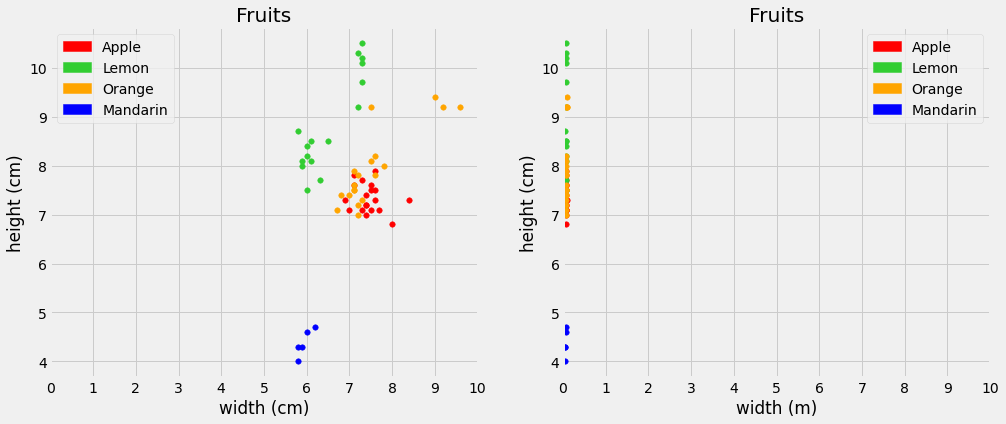

In [6]:
plt.subplots(figsize=(15, 6))
plt.subplot(1, 2, 1)

plt.scatter(fruit_df.loc[fruit_df['fruit_name']== 'apple']['width'], fruit_df.loc[fruit_df['fruit_name']== 'apple']['height'] , color='red', s=30)
plt.scatter(fruit_df.loc[fruit_df['fruit_name']== 'lemon']['width'], fruit_df.loc[fruit_df['fruit_name']== 'lemon']['height'] , color='limegreen', s=30)
plt.scatter(fruit_df.loc[fruit_df['fruit_name']== 'orange']['width'], fruit_df.loc[fruit_df['fruit_name']== 'orange']['height'] , color='orange', s=30)
plt.scatter(fruit_df.loc[fruit_df['fruit_name']== 'mandarin']['width'], fruit_df.loc[fruit_df['fruit_name']== 'mandarin']['height'] , color='blue', s=30)

r_patch = mpatches.Patch(color='red', label='Apple')
y_patch = mpatches.Patch(color='limegreen', label='Lemon')
o_patch = mpatches.Patch(color='orange', label='Orange')
m_patch = mpatches.Patch(color='blue', label='Mandarin')
plt.legend(handles=[r_patch, y_patch,o_patch, m_patch])
plt.xticks(np.arange(0,11))
plt.xlabel('width (cm)')
plt.ylabel('height (cm)')
plt.title("Fruits");

plt.subplot(1, 2, 2)
plt.scatter(fruit_df.loc[fruit_df['fruit_name']== 'apple']['width_meters'], fruit_df.loc[fruit_df['fruit_name']== 'apple']['height'] , color='red', s=30)
plt.scatter(fruit_df.loc[fruit_df['fruit_name']== 'lemon']['width_meters'], fruit_df.loc[fruit_df['fruit_name']== 'lemon']['height'] , color='limegreen', s=30)
plt.scatter(fruit_df.loc[fruit_df['fruit_name']== 'orange']['width_meters'], fruit_df.loc[fruit_df['fruit_name']== 'orange']['height'] , color='orange', s=30)
plt.scatter(fruit_df.loc[fruit_df['fruit_name']== 'mandarin']['width_meters'], fruit_df.loc[fruit_df['fruit_name']== 'mandarin']['height'] , color='blue', s=30)

r_patch = mpatches.Patch(color='red', label='Apple')
y_patch = mpatches.Patch(color='limegreen', label='Lemon')
o_patch = mpatches.Patch(color='orange', label='Orange')
m_patch = mpatches.Patch(color='blue', label='Mandarin')
plt.legend(handles=[r_patch, y_patch,o_patch, m_patch])
plt.xticks(np.arange(0,11))
plt.xlabel('width (m)')
plt.ylabel('height (cm)')
plt.title("Fruits");

To see this, suppose we classify a new fruit with width = 5cm and height = 7cm on the left graph and that same fruit on the right graph, width = 5/100 m, height = 7cm. Doing so, we find that the left graph records lemon as the 5 nearest neighbors! But with width recorded in meters, apple is the majority with $k = 5$ neighbors, and there are no lemons in sight!

In [7]:
closest_k(fruit_df[['width', 'height']], point= np.array([5,7]), k=5).join(fruit_df['fruit_name'])

,width,height,Distance_to_point,fruit_name
51,6.0,7.5,1.118034,lemon
52,5.9,8.0,1.345362,lemon
56,5.9,8.1,1.421267,lemon
55,6.3,7.7,1.476482,lemon
58,6.1,8.1,1.555635,lemon


In [8]:
closest_k(fruit_df[['width_meters', 'height']], point= np.array([5/100,7]), k=5).join(fruit_df['fruit_name'])

,width_meters,height,Distance_to_point,fruit_name
32,0.072,7.0,0.022000,orange
9,0.074,7.0,0.024000,apple
28,0.067,7.1,0.101435,orange
12,0.070,7.1,0.101980,apple
22,0.073,7.1,0.102611,apple


Therefore it is important the features are in the same units. They also need to be in the same scale. So here we normalize our features of interest to be between 0 and 1 before we classify any new values.

In [9]:
def minmax_scaling(x):
    "Convert any array of numbers"
    return (x - np.min(x))/(np.max(x)-np.min(x)) 

In [10]:
fruit_df['Normalized_width'] = minmax_scaling(fruit_df['width'])
fruit_df['Normalized_height'] = minmax_scaling(fruit_df['height'])

In [11]:
fruit_df.head(4)

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score,width_meters,Normalized_width,Normalized_height
0,1,apple,granny_smith,192,8.4,7.3,0.55,0.084,0.684211,0.507692
1,1,apple,granny_smith,180,8.0,6.8,0.59,0.080,0.578947,0.430769
2,1,apple,granny_smith,176,7.4,7.2,0.60,0.074,0.421053,0.492308
3,2,mandarin,mandarin,86,6.2,4.7,0.80,0.062,0.105263,0.107692


After normalization, we see the features of interest plotted below on the scale of 0 to 1.

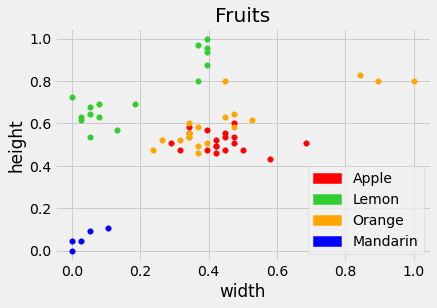

In [12]:
plt.scatter(fruit_df.loc[fruit_df['fruit_name']== 'apple']['Normalized_width'], fruit_df.loc[fruit_df['fruit_name']== 'apple']['Normalized_height'] , color='red', s=30)
plt.scatter(fruit_df.loc[fruit_df['fruit_name']== 'lemon']['Normalized_width'], fruit_df.loc[fruit_df['fruit_name']== 'lemon']['Normalized_height'] , color='limegreen', s=30)
plt.scatter(fruit_df.loc[fruit_df['fruit_name']== 'orange']['Normalized_width'], fruit_df.loc[fruit_df['fruit_name']== 'orange']['Normalized_height'] , color='orange', s=30)
plt.scatter(fruit_df.loc[fruit_df['fruit_name']== 'mandarin']['Normalized_width'], fruit_df.loc[fruit_df['fruit_name']== 'mandarin']['Normalized_height'] , color='blue', s=30)
r_patch = mpatches.Patch(color='red', label='Apple')
y_patch = mpatches.Patch(color='limegreen', label='Lemon')
o_patch = mpatches.Patch(color='orange', label='Orange')
m_patch = mpatches.Patch(color='blue', label='Mandarin')
plt.legend(handles=[r_patch, y_patch,o_patch, m_patch])
plt.xlabel('width')
plt.ylabel('height')
plt.title("Fruits");

At this point we have standardized the data, now we want to split this into training and testing data to determine a good model. Below we do this by randomly shuffling the data and taking a 80:20 split.

In [13]:
shuffled_fruit=fruit_df.sample(frac=1, random_state=1)

In [14]:
Train = shuffled_fruit.iloc[0:math.floor(len(shuffled_fruit)*0.8)]
Test = shuffled_fruit.iloc[math.floor(len(shuffled_fruit)*0.8):len(shuffled_fruit)]

In [15]:
X_train = Train[['Normalized_width', 'Normalized_height']]
Y_train = Train[['fruit_label']].rename(columns={"fruit_label": "Class"})
X_test = Test[['Normalized_width', 'Normalized_height']]
Y_test = Test[['fruit_label']].rename(columns={"fruit_label": "Class"})

Since our fruit can take on one of five categories, we change our majority function to return the majority class from a collection of finite classes.

In [16]:
def majority_multiclass(topkclasses):
    """returns the class with the majority 
    over the "Class" column"""
    
    return topkclasses['Class'].value_counts().idxmax()

We also modify our `closest_k` function in the previous section to take in our training data. The goal of this function is to call function `row_wise_distance` to compute the distance from every point in our training data to the new data and sort the resulting DataFrame to output the top $k$ neighbors closest to the new point of interest. 

In [17]:
def closest(X_train, Y_train, point, k):
    """Outputs a df containing the k closest rows in the training data to array 'point' """
    X_train = X_train.assign(Distance_to_point = X_train.apply(row_wise_distance, args=(point,), axis=1))
    X_train = X_train.sort_values('Distance_to_point') 
    X_train['Class'] = Y_train
    topk = X_train.head(k)
    return topk

Our goal is to classify not just one new data point, but a collection of new data. We want to iterate through all of the new data points in `X_test`, calculate $k$ nearest neighbors and find the majority classification label to assign as a predicted label for the `X_test` data. The function `classify` defined below does exactly that and stores the predicted label as a new column in the given test DataFrame.

In [18]:
def classify(X_train,Y_train, X_test, k):
    """Classify data in X_test using k-nearest neighbor classification with the given training table.
    Output is a DataFrame with X_test appended by a column of Class prediction"""
    n=X_test.shape[0] 
    
    pred_class = np.array([])
    for i in np.arange(n):
        topkclasses = closest(X_train,Y_train, X_test.iloc[i], k)
        pred_class = np.append(pred_class,majority_multiclass(topkclasses))
    
    report_df=X_test.copy()
    report_df['Predicted_Class']=pred_class
    
    return report_df

Before we use this function on our unseen test data, we need to choose a value of $k$ for this model by cross validation.

## Cross Validation

We use the training data and k-fold cross validation (as discussed in [Section 21.3: Features to Consider](../../21/3/Features_to_Consider.ipynb)) to tune the value of the number of neighbors, $k$, that is optimal in our situation. Here we split our training data into 4 (mostly) equal parts, of size 11 or 12, iterating through which portion serves as the validation set, and taking the average accuracy for a given value of $k$. By accuracy, we mean the total number of correctly classified labels divided by the total total number of classified points.

Since the training data is already randomized, we group the data directly from `X_train` and `Y_train`.

The `cross_valid` function cycles through values of $k$ from $k=1$ to $k=9$ and takes the average over 4 training and validation sets to compute one *averaged* accuracy for each $k$. We use this function to help us choose a value for $k$ to use on the test data.

In [19]:
def cross_valid(X_train, Y_train):
    '''Divides the train data into 4 parts and uses the third to validate the output
    and compute average accuracies for k in the range 1 to 9'''
    X = [X_train[0:12], X_train[12:12+12], X_train[24:24+12], X_train[36:36+11]] 
    Y = [Y_train[0:12], Y_train[12:12+12], Y_train[24:24+12], Y_train[36:36+11]]
    
    
    average_accuracies = []
    for my_k in np.array([1,2,3,4,5,6,7,8,9]):
        accuracies = []
        for i in np.arange(0,4):         
            excluded = np.arange(0,4)[~np.isin(np.arange(np.arange(0,4).size), i)]
            current_x_train =  pd.concat([X[excluded[0]], X[excluded[1]], X[excluded[2]]])
            current_y_train =  pd.concat([Y[excluded[0]], Y[excluded[1]], Y[excluded[2]]])
            
            output = classify(current_x_train, current_y_train, X[i], k = my_k)
            accuracies.append(sum(Y[i].Class == output.Predicted_Class)/len(Y[i]))
        average_accuracies.append(np.mean(accuracies))
        
    return average_accuracies           

In [20]:
cross_val_array = cross_valid(X_train, Y_train)

To see all of the accuracies from the `cross_valid` function, we display the value of $k$ and the corresponding accuracy below.

In [21]:
for i in np.arange(0,len(cross_val_array)):
    print("k = " + str(i+1)+ ': Accuracy: '+ str(cross_val_array[i]))

k = 1: Accuracy: 0.787878787878788
k = 2: Accuracy: 0.787878787878788
k = 3: Accuracy: 0.8522727272727273
k = 4: Accuracy: 0.8522727272727273
k = 5: Accuracy: 0.8314393939393939
k = 6: Accuracy: 0.8295454545454546
k = 7: Accuracy: 0.8087121212121212
k = 8: Accuracy: 0.8484848484848484
k = 9: Accuracy: 0.8068181818181819


The best accuracy achieved was about $85.2 \%$. But, notice we have a tie in accuracy. In this case, we choose the smallest value of $k$ that achieves the best accuracy, $k = 3$. A smaller $k$ will be quicker to compute and yields the same accuracy on our validation set.

Now that we have a value of $k$, we run the classifier on our test data using $k=3$!

In [22]:
output = classify(X_train,Y_train, X_test, k = 3)
output.head()

,Normalized_width,Normalized_height,Predicted_Class
56,0.026316,0.630769,4.0
1,0.578947,0.430769,1.0
16,0.473684,0.538462,1.0
0,0.684211,0.507692,3.0
15,0.500000,0.476923,1.0


We get a predicted class, which we can compare with the actual test labels and compute a percentage correct as a measure of accurary.

In [23]:
# check if the classification matches the "true" label
Y_test.Class == output.Predicted_Class

56     True
1      True
16     True
0     False
15     True
5      True
11    False
9      True
8     False
12    False
43     True
37    False
dtype: bool

In [24]:
sum(Y_test.Class == output.Predicted_Class)/len(Y_test)

0.5833333333333334

Based on these results we have an accuracy of about $58\% $.

This seems kind of low, but recall we have a small sample of data and only 2 features. Let's try to improve this by including another fruit feature.

## Higher Dimensions

We consider the `color_score` feature of the given fruit. To include this in our model, we first standardize that column of data. We can then visualize in a three dimensional setting. Note, we can include as many features, or dimensions, as we want that help us classify...we just might not be able to visualize anything higher than three dimensions.

In [25]:
fruit_df['Normalized_color'] = minmax_scaling(fruit_df['color_score'])

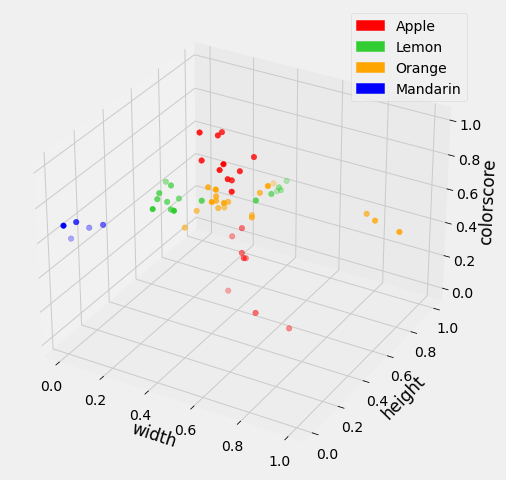

In [26]:
fig = plt.figure(figsize = (12,8))
ax = plt.axes(projection='3d')


ax.scatter3D(fruit_df.loc[fruit_df['fruit_name']== 'apple']['Normalized_width'], fruit_df.loc[fruit_df['fruit_name']== 'apple']['Normalized_height'], fruit_df.loc[fruit_df['fruit_name']== 'apple']['Normalized_color'] , color='red', s=30)
ax.scatter3D(fruit_df.loc[fruit_df['fruit_name']== 'lemon']['Normalized_width'], fruit_df.loc[fruit_df['fruit_name']== 'lemon']['Normalized_height'], fruit_df.loc[fruit_df['fruit_name']== 'lemon']['Normalized_color'] , color='limegreen', s=30)
ax.scatter3D(fruit_df.loc[fruit_df['fruit_name']== 'orange']['Normalized_width'], fruit_df.loc[fruit_df['fruit_name']== 'orange']['Normalized_height'], fruit_df.loc[fruit_df['fruit_name']== 'orange']['Normalized_color'] , color='orange', s=30)
ax.scatter3D(fruit_df.loc[fruit_df['fruit_name']== 'mandarin']['Normalized_width'], fruit_df.loc[fruit_df['fruit_name']== 'mandarin']['Normalized_height'], fruit_df.loc[fruit_df['fruit_name']== 'mandarin']['Normalized_color'] , color='blue', s=30);
r_patch = mpatches.Patch(color='red', label='Apple')
y_patch = mpatches.Patch(color='limegreen', label='Lemon')
o_patch = mpatches.Patch(color='orange', label='Orange')
m_patch = mpatches.Patch(color='blue', label='Mandarin')
ax.legend(handles=[r_patch, y_patch,o_patch, m_patch])
ax.set_xlabel('width')
ax.set_ylabel('height')
ax.set_zlabel('colorscore');

With one new feature added to our data, we shuffle and divide into training and test data. We can directly use the `cross_valid` function defined above to cross validate and determine a value for $k$ in this new setting.

In [27]:
shuffled_fruit=fruit_df.sample(frac=1, random_state=1)
Train = shuffled_fruit.iloc[0:math.floor(len(shuffled_fruit)*0.8)]
Test = shuffled_fruit.iloc[math.floor(len(shuffled_fruit)*0.8):len(shuffled_fruit)]


X_train = Train[['Normalized_width', 'Normalized_height', 'Normalized_color']]
Y_train = Train[['fruit_label']].rename(columns={"fruit_label": "Class"})
X_test = Test[['Normalized_width', 'Normalized_height', 'Normalized_color']]
Y_test = Test[['fruit_label']].rename(columns={"fruit_label": "Class"})

In [28]:
cross_val_array = cross_valid(X_train, Y_train)

for i in np.arange(0,len(cross_val_array)):
    print("k = " + str(i+1)+ ': Accuracy: '+ str(cross_val_array[i]))

k = 1: Accuracy: 0.9166666666666666
k = 2: Accuracy: 0.9166666666666666
k = 3: Accuracy: 0.8731060606060606
k = 4: Accuracy: 0.8958333333333333
k = 5: Accuracy: 0.9166666666666666
k = 6: Accuracy: 0.9166666666666666
k = 7: Accuracy: 0.8503787878787878
k = 8: Accuracy: 0.8503787878787878
k = 9: Accuracy: 0.7632575757575757


Extra feature information has improved validation accuracy and here we choose $k=1$ to determine the accuracy on our test data. Classifying our test data below, we see that our small test set of size 12 classifies every data point correctly! 

In [29]:
output = classify(X_train,Y_train, X_test, k = 1)

In [30]:
# check if the classification matches the "true" label
Y_test.Class == output.Predicted_Class

56    True
1     True
16    True
0     True
15    True
5     True
11    True
9     True
8     True
12    True
43    True
37    True
dtype: bool

In [31]:
sum(Y_test.Class == output.Predicted_Class)/len(Y_test)

1.0

In general, we find that kNN is an intuitive way to classify new data, as we just need a measure of distance and a number of neighbors to implement this method. We saw that we can include multiple features and classify into a finite number of classes. We were also able to test the accuracy of this method by using cross validation to choose a value for $k$ and count how many times our classification algorithm correctly identified the label.